# Finetune the Summary Grader

## Initialize

In [1]:
%%capture
from pathlib import Path
import pandas as pd
import numpy as np
!pip install SentencePiece
!pip install "ray[tune]"
!pip install wandb
import seaborn as sns

sns.set_theme(font='Liberation Serif',
              rc={'figure.figsize': (7.5,3.75),
                  'font.size': 11,
                  'figure.dpi': 300,
                 })

In [2]:
DATA = Path.cwd().parent / 'data'
SUMM_FOLDER = DATA / 'summaries_finetune'
TEXT_FILES = SUMM_FOLDER / 'text_files_copy'
SOURCE_TEXTS = SUMM_FOLDER / 'source_texts'

## Load and clean the data

In [3]:
summaries_df = pd.read_csv(SUMM_FOLDER / 'final_summaries_ai_aloe_fixed.csv')

from sklearn.preprocessing import MinMaxScaler
import numpy as np
  
# copy the data
df_normalized = summaries_df.copy()
  
# apply normalization techniques
df_normalized['content_pca'] = MinMaxScaler().fit_transform(np.array(df_normalized['content_pca']).reshape(-1,1))
df_normalized['paraphrase_pca'] = MinMaxScaler().fit_transform(np.array(df_normalized['paraphrase_pca']).reshape(-1,1))  

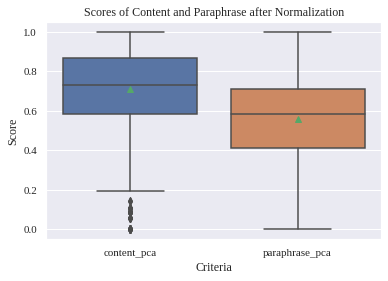

In [4]:
from matplotlib import pyplot as plt
sns.boxplot(x="variable", y="value", data=pd.melt(df_normalized[['content_pca', 'paraphrase_pca']]), showmeans=True)

plt.title('Scores of Content and Paraphrase after Normalization')
plt.xlabel('Criteria')
plt.ylabel('Score')
plt.show()

In [5]:
df_normalized.describe().to_csv('table.csv')

### Seperate out a test set to avoid prompt effect

In [6]:
source_texts = df_normalized['source_text_filename_clean'].value_counts().to_frame().reset_index()
texts_to_remove = list(source_texts.iloc[15:31]['index'])

In [7]:
# source_texts = df_normalized['source_text'].value_counts().to_frame()
# texts_to_remove = list(source_texts.iloc[1:6].index)

test_df = df_normalized[df_normalized['source_text_filename_clean'].isin(texts_to_remove)]
train_df = df_normalized[df_normalized['source_text_filename_clean'].isin(texts_to_remove) == False]
print('test n:', len(test_df))
print('train n:', len(train_df))

test n: 703
train n: 3987


## Transformer time

In [8]:
from datasets import load_dataset, load_metric, Dataset, Value, ClassLabel, Features, DatasetDict
# from transformers import LongformerTokenizer, LongformerForSequenceClassification, LongformerConfig
from transformers import RobertaTokenizer, RobertaForSequenceClassification, RobertaConfig, DataCollatorWithPadding, Trainer, TrainingArguments, EarlyStoppingCallback
from transformers import LongformerTokenizer, LongformerForSequenceClassification, LongformerConfig


import torch
seed = 42
model_name =  'roberta-base'# #"google/bigbird-roberta-base"'allenai/longformer-base-4096'# 
tokenizer = RobertaTokenizer.from_pretrained(model_name)# LongformerTokenizer.from_pretrained(model_name)#, padding=True)# #
#torch.cuda.empty_cache()

device = torch.device("cpu")
if torch.cuda.is_available():
    device = torch.device("cuda")

### Build datasets

In [9]:
def buildDataset(df):
    full_dataset = Dataset.from_pandas(df, preserve_index=False)
    # 70% train, 30% test
    train_valid = full_dataset.train_test_split(test_size=0.176, seed=seed)
    # gather everyone if you want to have a single DatasetDict
    final_dataset = DatasetDict({
        'train': train_valid['train'],
        'valid': train_valid['test']})
    return final_dataset

In [10]:
content_df = train_df[['text', 'content_pca']]
content_df.columns = ['text', 'labels']
content_ds = buildDataset(content_df)

paraphrase_df = train_df[['text', 'paraphrase_pca']]
paraphrase_df.columns = ['text', 'labels']
paraphrase_ds = buildDataset(paraphrase_df)

In [11]:
# this adds the test set in that we seperated earlier
content_ds['test'] = Dataset.from_pandas(test_df[['text', 'content_pca']].rename(columns={'content_pca':'labels'}), preserve_index=False)
paraphrase_ds['test'] = Dataset.from_pandas(test_df[['text', 'paraphrase_pca']].rename(columns={'paraphrase_pca':'labels'}), preserve_index=False)

In [12]:
model_name = model_name
tokenizer = tokenizer

In [21]:
# tokenize them
def tokenize_inputs(example):
    return tokenizer(example['text'])#, truncation = True)

content_ds_t = content_ds.map(tokenize_inputs, batched=True)
paraphrase_ds_t = paraphrase_ds.map(tokenize_inputs, batched=True)

  0%|          | 0/4 [00:00<?, ?ba/s]

Token indices sequence length is longer than the specified maximum sequence length for this model (519 > 512). Running this sequence through the model will result in indexing errors


  0%|          | 0/1 [00:00<?, ?ba/s]

  0%|          | 0/1 [00:00<?, ?ba/s]

  0%|          | 0/4 [00:00<?, ?ba/s]

  0%|          | 0/1 [00:00<?, ?ba/s]

  0%|          | 0/1 [00:00<?, ?ba/s]

In [25]:
content_ds_t['train']['input_ids']

for i in content_ds_t['train']['input_ids']:
    if len(i) > 500:
        print(len(i))

519
664
536
578
525
685
570
523
684


### Define metrics

In [15]:
from sklearn.metrics import mean_squared_error, r2_score, mean_squared_error, mean_absolute_error
from scipy.stats import pearsonr 

def compute_metrics_for_regression(eval_pred):
    logits, labels = eval_pred
    mse = mean_squared_error(labels, logits)
    rmse = mean_squared_error(labels, logits, squared=False)
    mae = mean_absolute_error(labels, logits)
    r2 = r2_score(labels, logits)
    smape = 1/len(labels) * np.sum(2 * np.abs(logits-labels) / (np.abs(labels) + np.abs(logits))*100)

    return {"mse": mse, "rmse": rmse, "mae": mae, "r2": r2, "smape": smape}

### Set hyperparameters

In [16]:
learning_rate = 3e-05
batch_size = 36
seed = 42
num_epochs = 6
da_model_name = './results/checkpoint-78500'

def model_init():
    return RobertaForSequenceClassification.from_pretrained(model_name,
                                                              num_labels=1).to(device)
# def model_init():
#     return RobertaForSequenceClassification.from_pretrained(da_model_name,
#                                                               num_labels=1).to(device)
data_collator = DataCollatorWithPadding(tokenizer=tokenizer)

### Train the content model

In [17]:
trainer = Trainer(
    model_init=model_init,
)

training_args = TrainingArguments(
    output_dir = f'./results/roberta_content_checkpoints',
    optim = 'adamw_torch',
    num_train_epochs = num_epochs,
    per_device_train_batch_size = batch_size,
    per_device_eval_batch_size = batch_size,
    weight_decay = 0.01,
    learning_rate = learning_rate,
    logging_dir = f'./logs/content',
    save_total_limit = 10,
    load_best_model_at_end = True,
    metric_for_best_model = 'mse',
    evaluation_strategy = "epoch",
    save_strategy = "epoch", 
    greater_is_better = False,
    seed=seed,
    log_level = 'error',  # took me ages to find these options
    disable_tqdm = False, # enable output cell scrolling in JupyterLab for even more beautiful output :D
) 

    # Call the Trainer
content_trainer = Trainer(
    model_init = model_init,
    args = training_args,
    data_collator=data_collator,
    train_dataset = content_ds_t['train'],
    eval_dataset = content_ds_t['valid'],
    compute_metrics = compute_metrics_for_regression,
    #callbacks = [EarlyStoppingCallback(early_stopping_patience=3)]
)

# Train the model
content_trainer.train()

loading configuration file https://huggingface.co/roberta-base/resolve/main/config.json from cache at /home/jovyan/.cache/huggingface/transformers/733bade19e5f0ce98e6531021dd5180994bb2f7b8bd7e80c7968805834ba351e.35205c6cfc956461d8515139f0f8dd5d207a2f336c0c3a83b4bc8dca3518e37b
Model config RobertaConfig {
  "architectures": [
    "RobertaForMaskedLM"
  ],
  "attention_probs_dropout_prob": 0.1,
  "bos_token_id": 0,
  "classifier_dropout": null,
  "eos_token_id": 2,
  "hidden_act": "gelu",
  "hidden_dropout_prob": 0.1,
  "hidden_size": 768,
  "id2label": {
    "0": "LABEL_0"
  },
  "initializer_range": 0.02,
  "intermediate_size": 3072,
  "label2id": {
    "LABEL_0": 0
  },
  "layer_norm_eps": 1e-05,
  "max_position_embeddings": 514,
  "model_type": "roberta",
  "num_attention_heads": 12,
  "num_hidden_layers": 12,
  "pad_token_id": 1,
  "position_embedding_type": "absolute",
  "transformers_version": "4.20.1",
  "type_vocab_size": 1,
  "use_cache": true,
  "vocab_size": 50265
}

loading 

Epoch,Training Loss,Validation Loss,Mse,Rmse,Mae,R2,Smape
1,No log,0.025309,0.025309,0.159087,0.114396,0.386654,21185.021368
2,No log,0.026084,0.026084,0.161507,0.121129,0.367853,21190.992877
3,No log,0.022764,0.022764,0.150879,0.116279,0.448314,21420.062678
4,No log,0.015061,0.015061,0.122725,0.089890,0.634992,22241.850427
5,No log,0.012957,0.012957,0.113831,0.083353,0.685982,22621.682336
6,0.021100,0.014606,0.014606,0.120855,0.089983,0.646032,22809.386040


TrainOutput(global_step=552, training_loss=0.020089578369389408, metrics={'train_runtime': 300.5756, 'train_samples_per_second': 65.574, 'train_steps_per_second': 1.836, 'total_flos': 3155141377449306.0, 'train_loss': 0.020089578369389408, 'epoch': 6.0})

### Train the paraphrase model

In [18]:
trainer = Trainer(
    model_init=model_init,
)

training_args = TrainingArguments(
    output_dir = f'./results/roberta_paraphrase_checkpoints',
    optim = 'adamw_torch',
    num_train_epochs = num_epochs,
    per_device_train_batch_size = batch_size,
    per_device_eval_batch_size = batch_size,
    weight_decay = 0.01,
    learning_rate = learning_rate,
    logging_dir = f'./logs/paraphrase',
    save_total_limit = 10,
    load_best_model_at_end = True,
    metric_for_best_model = 'mse',
    evaluation_strategy = "epoch",
    save_strategy = "epoch",
    greater_is_better = False,
    seed=seed,
    log_level = 'error', # took me ages to find these options
    disable_tqdm = False, # enable output cell scrolling in JupyterLab for even more beautiful output :D
) 

    # Call the Trainer
paraphrase_trainer = Trainer(
    model_init = model_init,
    args = training_args,
    data_collator=data_collator,
    train_dataset = paraphrase_ds_t['train'],
    eval_dataset = paraphrase_ds_t['valid'],
    compute_metrics = compute_metrics_for_regression,
    #callbacks = [EarlyStoppingCallback(early_stopping_patience=3)]
)

# Train the model
paraphrase_trainer.train()

loading configuration file https://huggingface.co/roberta-base/resolve/main/config.json from cache at /home/jovyan/.cache/huggingface/transformers/733bade19e5f0ce98e6531021dd5180994bb2f7b8bd7e80c7968805834ba351e.35205c6cfc956461d8515139f0f8dd5d207a2f336c0c3a83b4bc8dca3518e37b
Model config RobertaConfig {
  "architectures": [
    "RobertaForMaskedLM"
  ],
  "attention_probs_dropout_prob": 0.1,
  "bos_token_id": 0,
  "classifier_dropout": null,
  "eos_token_id": 2,
  "hidden_act": "gelu",
  "hidden_dropout_prob": 0.1,
  "hidden_size": 768,
  "id2label": {
    "0": "LABEL_0"
  },
  "initializer_range": 0.02,
  "intermediate_size": 3072,
  "label2id": {
    "LABEL_0": 0
  },
  "layer_norm_eps": 1e-05,
  "max_position_embeddings": 514,
  "model_type": "roberta",
  "num_attention_heads": 12,
  "num_hidden_layers": 12,
  "pad_token_id": 1,
  "position_embedding_type": "absolute",
  "transformers_version": "4.20.1",
  "type_vocab_size": 1,
  "use_cache": true,
  "vocab_size": 50265
}

loading 

Epoch,Training Loss,Validation Loss,Mse,Rmse,Mae,R2,Smape
1,No log,0.023556,0.023556,0.153480,0.118648,0.382470,25280.584046
2,No log,0.032384,0.032384,0.179956,0.142187,0.151040,28754.592593
3,No log,0.024550,0.024550,0.156684,0.122110,0.356420,25914.182336
4,No log,0.016516,0.016516,0.128514,0.096117,0.567034,28421.182336
5,No log,0.014592,0.014592,0.120797,0.090674,0.617467,28276.569801
6,0.023000,0.016006,0.016006,0.126513,0.094215,0.580409,27733.638177


TrainOutput(global_step=552, training_loss=0.021905332803726196, metrics={'train_runtime': 300.9898, 'train_samples_per_second': 65.484, 'train_steps_per_second': 1.834, 'total_flos': 3155141377449306.0, 'train_loss': 0.021905332803726196, 'epoch': 6.0})

## Evaluate the models on the test groups

(array([0.8216409431233901], dtype=object), 2.7233747182451042e-173)


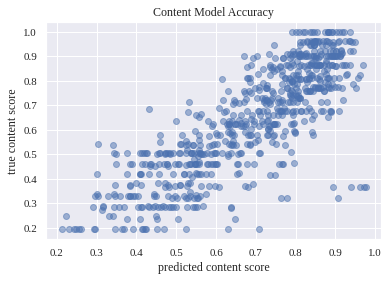

In [19]:
import scipy.stats

con_preds, con_labs, con_metrics = content_trainer.predict(content_ds_t['test'])
con_actual = content_ds_t['test']['labels']
print(scipy.stats.pearsonr(con_actual, con_preds))

from matplotlib import pyplot as plt
con_preds.flatten()
plt.scatter(con_preds, con_actual, alpha=0.5)
plt.ylabel('true content score')
plt.xlabel('predicted content score')
plt.title('Content Model Accuracy')
plt.show()

In [ ]:
content_ds_t

(array([0.599488939349459], dtype=object), 8.163247401324821e-70)


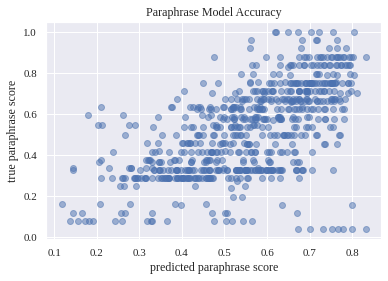

In [20]:
para_preds, para_labs, para_metrics = paraphrase_trainer.predict(paraphrase_ds_t['test'])
paraphrase_actual = paraphrase_ds_t['test']['labels']
print(scipy.stats.pearsonr(paraphrase_actual, para_preds))

from matplotlib import pyplot as plt
para_preds.flatten()
plt.scatter(para_preds, paraphrase_actual, alpha=0.5)
plt.ylabel('true paraphrase score')
plt.xlabel('predicted paraphrase score')
plt.title('Paraphrase Model Accuracy')
plt.show()

In [21]:
paraphrase_trainer.save_model(SUMM_FOLDER / 'paraphrase_model_roberta_seperate_test')
content_trainer.save_model(SUMM_FOLDER / 'content_model_roberta_seperate_test')
tokenizer.save_pretrained(SUMM_FOLDER / 'paraphrase_model_roberta_seperate_test/tokenizer.json')
tokenizer.save_pretrained(SUMM_FOLDER / 'content_model_roberta_seperate_test/tokenizer.json')

('/home/jovyan/shared/2022_09_21_textbook/data/summaries_finetune/content_model_roberta_seperate_test/tokenizer.json/tokenizer_config.json',
 '/home/jovyan/shared/2022_09_21_textbook/data/summaries_finetune/content_model_roberta_seperate_test/tokenizer.json/special_tokens_map.json',
 '/home/jovyan/shared/2022_09_21_textbook/data/summaries_finetune/content_model_roberta_seperate_test/tokenizer.json/vocab.json',
 '/home/jovyan/shared/2022_09_21_textbook/data/summaries_finetune/content_model_roberta_seperate_test/tokenizer.json/merges.txt',
 '/home/jovyan/shared/2022_09_21_textbook/data/summaries_finetune/content_model_roberta_seperate_test/tokenizer.json/added_tokens.json')